In [24]:
import importlib
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import numpy as np

from utils import data_utils

run_folder_kcm = "../results/full_run/kcm/models/"
run_folder_atb = "../results/full_run/atb/models/"
run_folder_mix = "../results/full_run_nosch/kcm_atb/models/"
run_folder_rut = "../results/full_run_nosch/rut/models/"

In [25]:
# Hyperparam results per network:
# CONV (128, 64, 3, 0.1)
# FF (128, 128, 2, 0.2)
# GRU (128, 64, 2, 0.05)
# TRSF (128, 64, 3, 0.1)

# KCM
# 512, 16, 2, 0.4 (TRSF)
# 512, 16, 5, 0.1
# 512, 128, 4, 0.4
# 128, 128, 2, 0.2 (FF)
# 128, 128, 2, 0.05 (GRU, CONV)
# 512, 16, 4, 0.2
# 1024, 16, 4, 0.1

# Model Epochs TestLoss
# CONV_0	10.000000	18.066327
# FF_0	11.333333	168.559759
# GRU_0	16.000000	18.540478
# TRSF_0	10.000000	22.919503

# CONV_0	10.000000	17.851481
# FF_0	11.333333	157.528422
# GRU_0	10.000000	22.917446
# TRSF_0	10.000000	22.915722

# CONV_0	12.0	15.852690
# FF_0	14.0	153.020960
# GRU_0	10.0	22.916604
# TRSF_0	10.0	22.912308

# CONV_0	12.8	15.829175
# FF_0	38.8	137.929590
# GRU_0	10.0	16.677470
# TRSF_0	10.0	22.853009

# CONV_1	12.8	15.750058
# FF_1	38.0	138.345676
# GRU_1	10.0	16.506545
# TRSF_1	10.0	22.851783

# CONV_0	10.0	17.629307
# FF_0	11.0	158.601257
# GRU_0	10.0	22.885823
# TRSF_0	10.0	22.888074

# CONV_1	10.0	18.191666
# FF_1	13.0	157.479233
# GRU_1	10.0	22.871649
# TRSF_1	10.0	22.862472


# AtB
# 512, 32, 3, 0.2
# 512, 32, 5, 0.4
# 512, 16, 2, 0.4
# 128, 32, 4, 0.2
# 128, 64, 5, 0.05 (CONV, FF, GRU, TRSF)

# CONV_0	12.666667	7.069618
# FF_0	19.333333	63.465285
# GRU_0	17.333333	9.175895
# TRSF_0	16.000000	9.075986

# CONV_0	12.000000	6.991179
# FF_0	18.000000	67.876277
# GRU_0	16.666667	9.161330
# TRSF_0	20.000000	9.001094

# CONV_0	14.000000	7.567914
# FF_0	23.333333	66.901993
# GRU_0	20.000000	9.058873
# TRSF_0	16.000000	9.404305

# CONV_0	10.8	6.135663
# FF_0	17.2	63.238688
# GRU_0	11.6	8.897823
# TRSF_0	11.6	8.895937

# CONV_1	10.0	6.058242
# FF_1	19.2	60.404724
# GRU_1	10.0	8.898676
# TRSF_1	10.8	8.893464

In [26]:
# Need to combine model results for all models
model_list = [x for x in os.listdir(run_folder_kcm) if (x[-3:]!="pkl" and x!=".DS_Store")]
all_model_results = []
all_model_times = []
all_model_gen_results = []
all_model_curves = []
for i, m in enumerate(model_list):
    training_results = data_utils.load_pkl(f"{run_folder_kcm}{m}/model_results.pkl")
    results_df, time_df = data_utils.extract_results(training_results, "Seattle")
    curve_df = data_utils.extract_lightning_results(m, f"{run_folder_kcm}{m}/logs/{m}", "Seattle")
    curve_df = curve_df[curve_df["Loss Set"].isin(["Train","Valid"])]
    if m[-4:]!="GRID":
        gen_results = data_utils.load_pkl(f"{run_folder_kcm}{m}/model_generalization_results.pkl")
        gen_df = data_utils.extract_gen_results(gen_results, "Seattle")
    if i!=0:
        results_df = results_df[results_df['Model']==m]
        time_df = time_df[time_df['Model']==m]
        gen_df = gen_df[gen_df['Model']==m]
    all_model_results.append(results_df)
    all_model_times.append(time_df)
    all_model_gen_results.append(gen_df)
    all_model_curves.append(curve_df)
kcm_result_df = pd.concat(all_model_results).sort_values(["Model","Fold"])
kcm_time_df = pd.concat(all_model_times).sort_values(["Model","Fold"])
kcm_gen_df = pd.concat(all_model_gen_results).sort_values(["Model","Fold"])
kcm_curve_df = pd.concat(all_model_curves).sort_values(["Model","Fold"])
kcm_baseline_df = kcm_gen_df[kcm_gen_df['Loss']=="Train_Losses"].copy()
kcm_baseline_df['Loss'] = "Network Baseline"
kcm_baseline_df = kcm_baseline_df[['Model','City','Loss','Fold','MAPE','RMSE','MAE']]

# Need to combine model results for all models
model_list = [x for x in os.listdir(run_folder_atb) if (x[-3:]!="pkl" and x!=".DS_Store")]
all_model_results = []
all_model_times = []
all_model_gen_results = []
all_model_curves = []
for i, m in enumerate(model_list):
    training_results = data_utils.load_pkl(f"{run_folder_atb}{m}/model_results.pkl")
    results_df, time_df = data_utils.extract_results(training_results, "Trondheim")
    curve_df = data_utils.extract_lightning_results(m, f"{run_folder_atb}{m}/logs/{m}", "Trondheim")
    curve_df = curve_df[curve_df["Loss Set"].isin(["Train","Valid"])]
    if m[-4:]!="GRID":
        gen_results = data_utils.load_pkl(f"{run_folder_atb}{m}/model_generalization_results.pkl")
        gen_df = data_utils.extract_gen_results(gen_results, "Trondheim")
    if i!=0:
        results_df = results_df[results_df['Model']==m]
        time_df = time_df[time_df['Model']==m]
        gen_df = gen_df[gen_df['Model']==m]
    all_model_results.append(results_df)
    all_model_times.append(time_df)
    all_model_gen_results.append(gen_df)
    all_model_curves.append(curve_df)
atb_result_df = pd.concat(all_model_results).sort_values(["Model","Fold"])
atb_time_df = pd.concat(all_model_times).sort_values(["Model","Fold"])
atb_gen_df = pd.concat(all_model_gen_results).sort_values(["Model","Fold"])
atb_curve_df = pd.concat(all_model_curves).sort_values(["Model","Fold"])
atb_baseline_df = atb_gen_df[atb_gen_df['Loss']=="Train_Losses"].copy()
atb_baseline_df['Loss'] = "Network Baseline"
atb_baseline_df = atb_baseline_df[['Model','City','Loss','Fold','MAPE','RMSE','MAE']]

In [27]:
model_curves_df = pd.concat([kcm_curve_df, atb_curve_df])
print(f"All Unique NN Models: {pd.unique(model_curves_df['Model'])}")

All Unique NN Models: ['CONV' 'CONV_GTFS' 'DEEP_TTE' 'DEEP_TTE_GTFS' 'FF' 'FF_GTFS' 'GRU'
 'GRU_GRID' 'GRU_GTFS' 'TRSF' 'TRSF_GRID' 'TRSF_GTFS']


### Model Performance

In [28]:
kcm_result_df.groupby(["Model"])[["MAPE"]].agg(["mean","std"])

MAPE          
                mean       std
Model                         
AVG            0.310  0.000000
CONV           0.122  0.004472
CONV_GTFS      0.116  0.005477
DEEP_TTE       0.130  0.000000
DEEP_TTE_GTFS  0.130  0.000000
FF             0.176  0.013416
FF_GTFS        0.168  0.013038
GRU            0.128  0.004472
GRU_GRID       0.098  0.008367
GRU_GTFS       0.120  0.007071
PER_TIM        0.290  0.000000
SCH            0.360  0.000000
TRSF           0.148  0.004472
TRSF_GRID      0.150  0.000000
TRSF_GTFS      0.148  0.004472

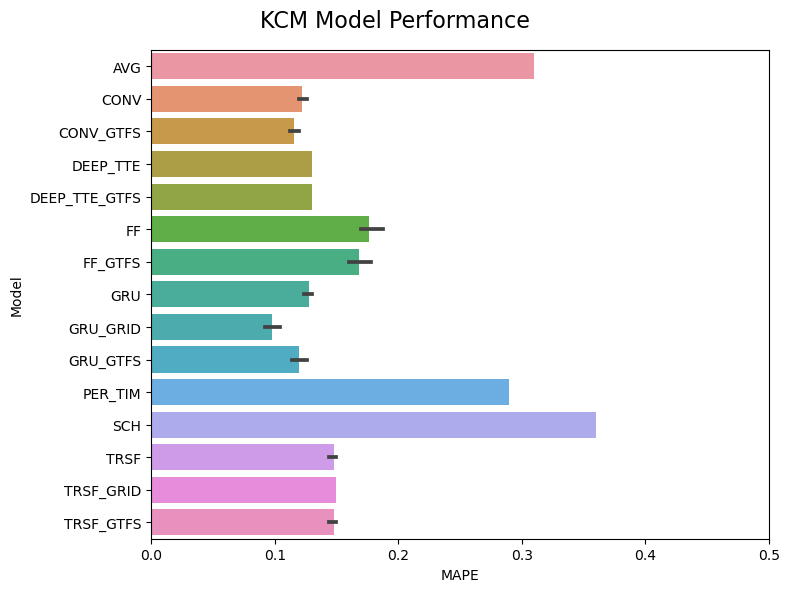

In [29]:
plot_data = kcm_result_df
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.barplot(plot_data, x="MAPE", y="Model", ax=axes)
axes.set_xlim([0, 0.5])
fig.suptitle('KCM Model Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_performances_kcm.png", dpi=600, bbox_inches='tight')

In [30]:
atb_result_df.groupby(["Model"])[["MAPE"]].agg(["mean","std"])

MAPE          
                mean       std
Model                         
AVG            0.230  0.000000
CONV           0.074  0.005477
CONV_GTFS      0.072  0.004472
DEEP_TTE       0.100  0.010000
DEEP_TTE_GTFS  0.106  0.015166
FF             0.140  0.010000
FF_GTFS        0.112  0.013038
GRU            0.074  0.005477
GRU_GRID       0.058  0.004472
GRU_GTFS       0.078  0.010954
PER_TIM        0.150  0.000000
SCH            0.260  0.000000
TRSF           0.100  0.000000
TRSF_GRID      0.100  0.000000
TRSF_GTFS      0.100  0.000000

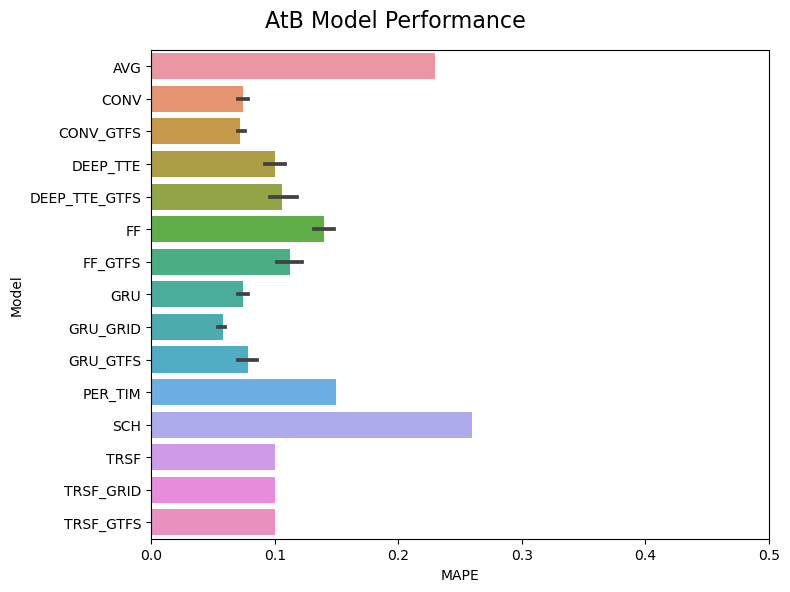

In [31]:
plot_data = atb_result_df
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.barplot(plot_data, x="MAPE", y="Model", ax=axes)
axes.set_xlim([0, 0.5])
fig.suptitle('AtB Model Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_performances_atb.png", dpi=600, bbox_inches='tight')

### Training Time

In [32]:
# plot_data = kcm_time_df[~kcm_time_df['Model'].isin(["AVG","SCH","PER_TIM"])]
# fig, axes = plt.subplots(1,1)
# fig.set_figheight(6)
# fig.set_figwidth(8)
# sns.barplot(plot_data, x="Time", y="Model", hue="Model", dodge=False)
# axes.set_ylabel("Model")
# axes.set_xlabel("Training Time (s)")
# fig.suptitle('Per-Fold Model Training Time On KCM', fontsize=16)
# fig.tight_layout()
# plt.savefig("../plots/model_train_time_kcm.png", dpi=600, bbox_inches='tight')

In [33]:
# plot_data = atb_time_df[~atb_time_df['Model'].isin(["AVG","SCH","PER_TIM"])]
# fig, axes = plt.subplots(1,1)
# fig.set_figheight(6)
# fig.set_figwidth(8)
# sns.barplot(plot_data, x="Time", y="Model", hue="Model", dodge=False)
# axes.set_ylabel("Model")
# axes.set_xlabel("Training Time (s)")
# fig.suptitle('Per-Fold Model Training Time On AtB', fontsize=16)
# fig.tight_layout()
# plt.savefig("../plots/model_train_time_atb.png", dpi=600, bbox_inches='tight')

### Training Curves

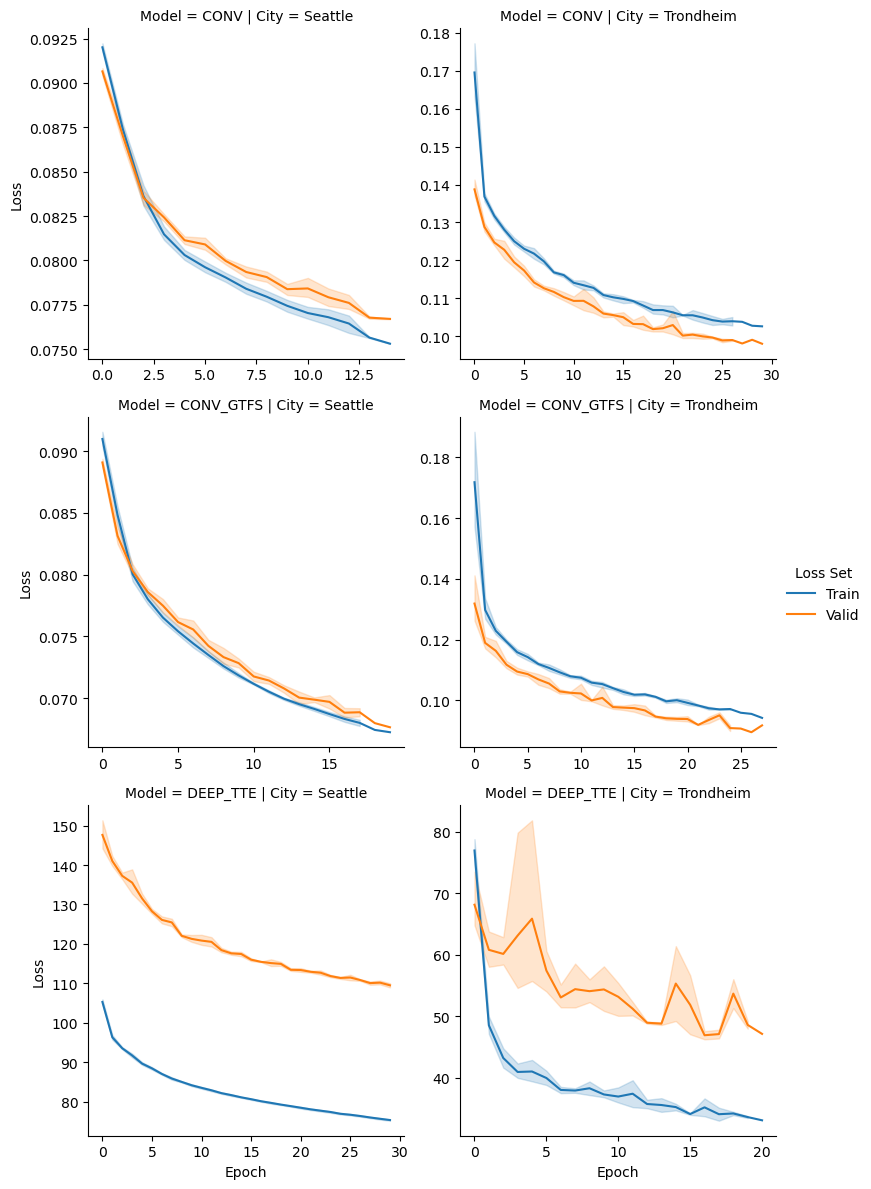

In [34]:
model_list = pd.unique(model_curves_df['Model'])
plot_data = model_curves_df[model_curves_df['Model'].isin(model_list[:3])]
g = sns.FacetGrid(data=plot_data, col="City", row="Model", hue="Loss Set", hue_order=["Train","Valid"], height=4, sharex=False, sharey=False)
g.map(sns.lineplot, "Epoch", "Loss")
g.add_legend()
plt.savefig(f"../plots/model_curves_1.png", dpi=600, bbox_inches='tight')

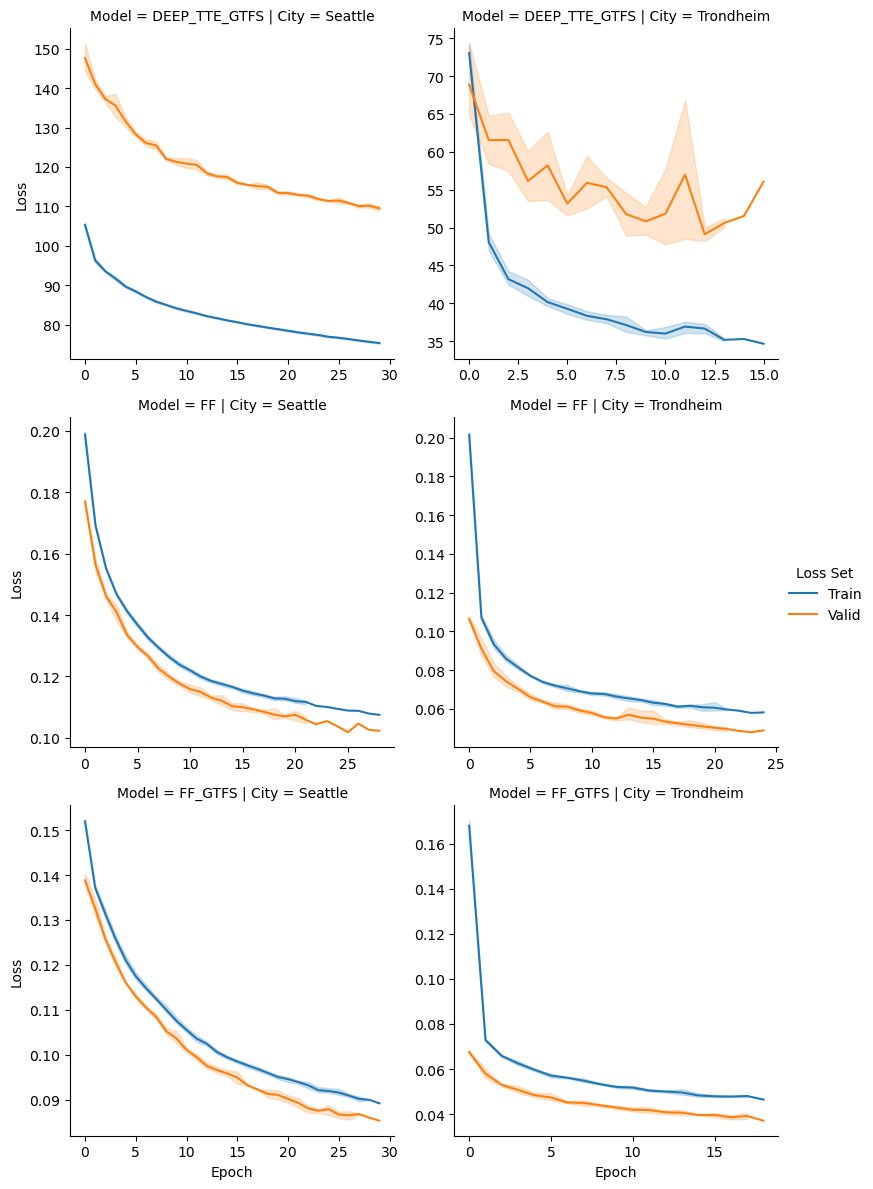

In [35]:
model_list = pd.unique(model_curves_df['Model'])
plot_data = model_curves_df[model_curves_df['Model'].isin(model_list[3:6])]
g = sns.FacetGrid(data=plot_data, col="City", row="Model", hue="Loss Set", hue_order=["Train","Valid"], height=4, sharex=False, sharey=False)
g.map(sns.lineplot, "Epoch", "Loss")
g.add_legend()
plt.savefig(f"../plots/model_curves_2.png", dpi=600, bbox_inches='tight')

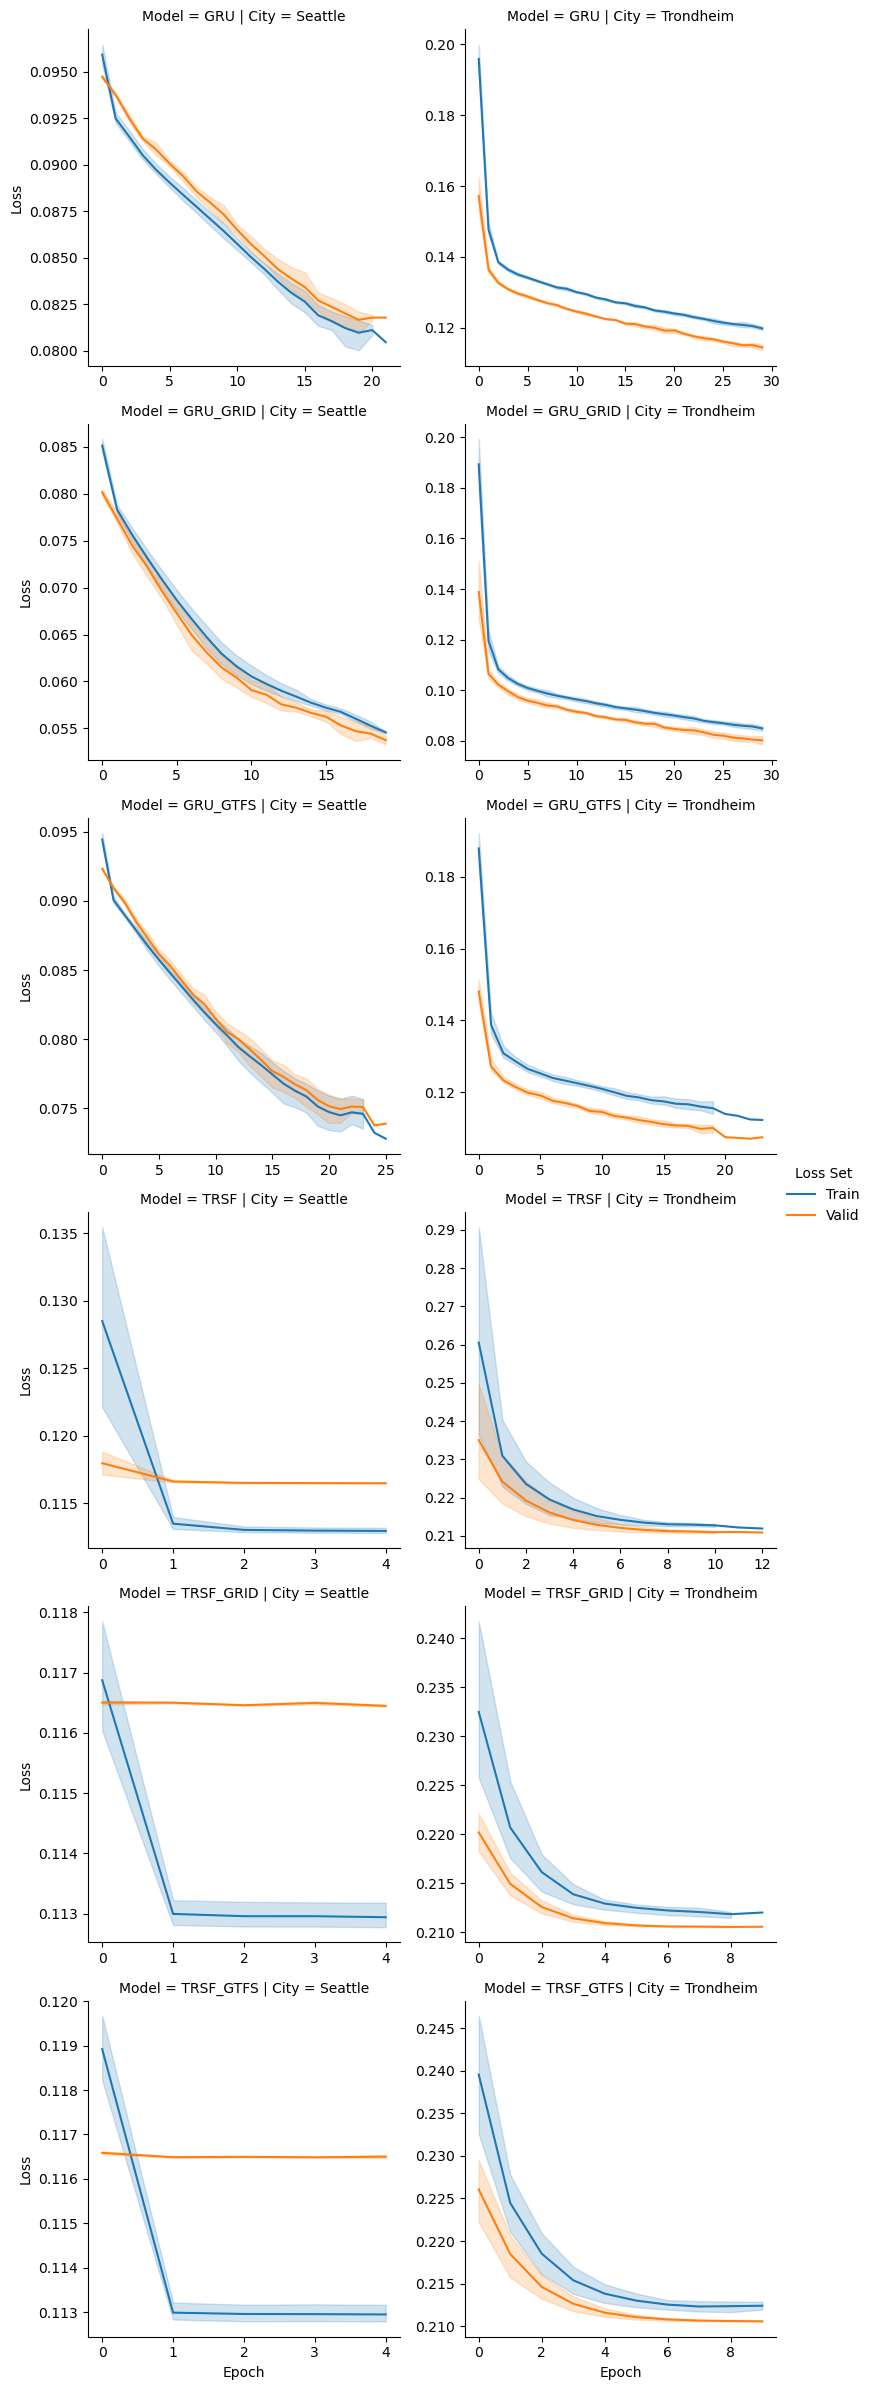

In [36]:
model_list = pd.unique(model_curves_df['Model'])
plot_data = model_curves_df[model_curves_df['Model'].isin(model_list[6:])]
g = sns.FacetGrid(data=plot_data, col="City", row="Model", hue="Loss Set", hue_order=["Train","Valid"], height=4, sharex=False, sharey=False)
g.map(sns.lineplot, "Epoch", "Loss")
g.add_legend()
plt.savefig(f"../plots/model_curves_3.png", dpi=600, bbox_inches='tight')

### Generalization (Across Networks)

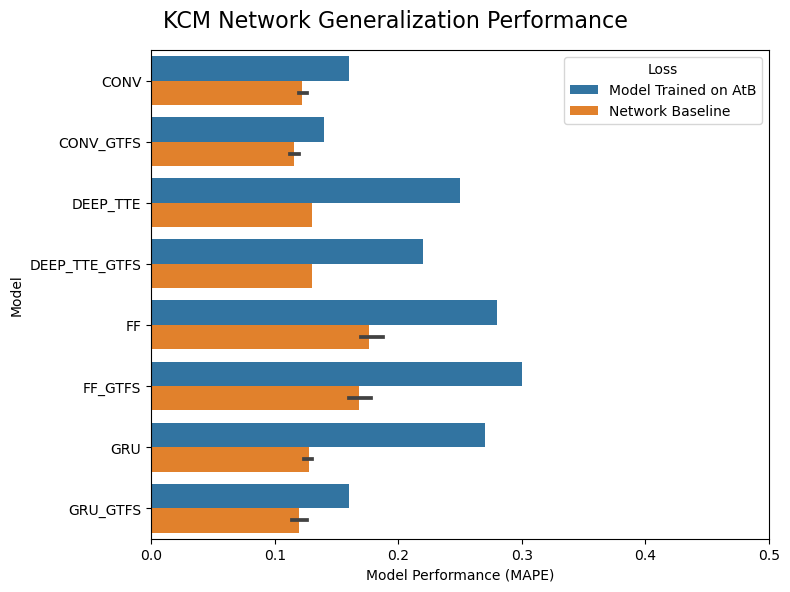

In [37]:
plot_data = atb_gen_df[atb_gen_df['Loss']=="Test_Losses"].copy()
plot_data = pd.concat([plot_data, kcm_baseline_df])
plot_data = plot_data[~plot_data['Model'].isin(["AVG","SCH","PER_TIM","TRSF","TRSF_GTFS"])]
plot_data['Loss'] = plot_data['Loss'].replace(["Test_Losses"],["Model Trained on AtB"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.barplot(plot_data, x="MAPE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0,.5])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAPE)")
fig.suptitle('KCM Network Generalization Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_generalization_kcm.png", dpi=600, bbox_inches='tight')

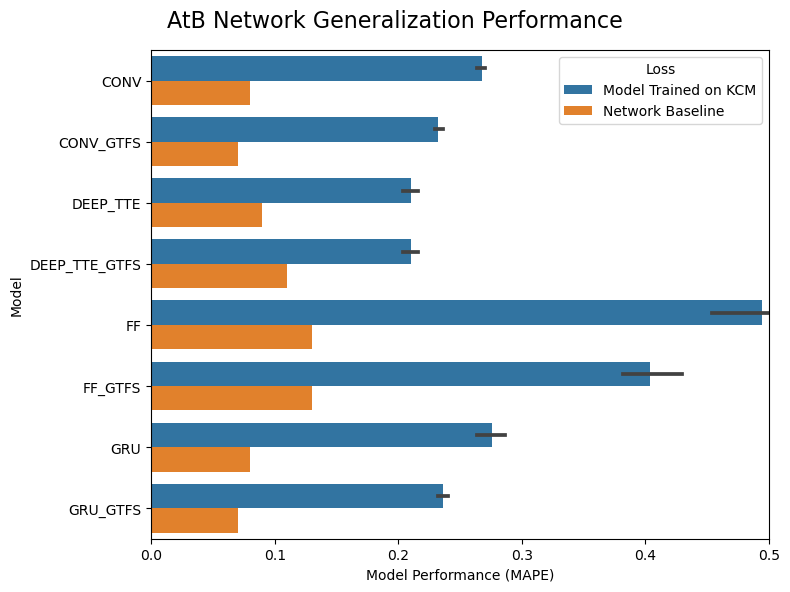

In [38]:
plot_data = kcm_gen_df[kcm_gen_df['Loss']=="Test_Losses"].copy()
plot_data = pd.concat([plot_data, atb_baseline_df])
plot_data = plot_data[~plot_data['Model'].isin(["AVG","SCH","PER_TIM","TRSF","TRSF_GTFS"])]
plot_data['Loss'] = plot_data['Loss'].replace(["Test_Losses"],["Model Trained on KCM"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.barplot(plot_data, x="MAPE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0, .5])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAPE)")
fig.suptitle('AtB Network Generalization Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_generalization_atb.png", dpi=600, bbox_inches='tight')

### Generalization (Within Network)

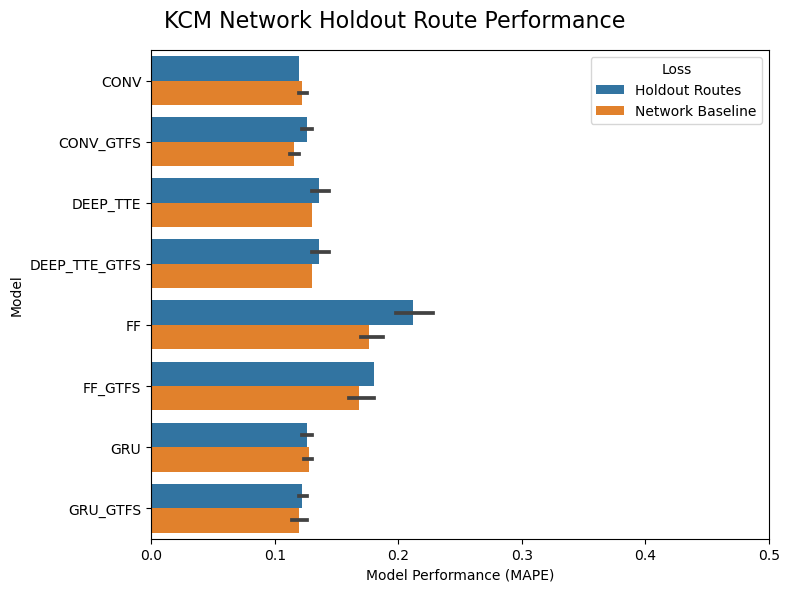

In [39]:
plot_data = kcm_gen_df[kcm_gen_df['Loss']=="Holdout_Losses"].copy()
plot_data = pd.concat([plot_data, kcm_baseline_df])
plot_data = plot_data[~plot_data['Model'].isin(["AVG","SCH","PER_TIM","TRSF","TRSF_GTFS"])]
plot_data['Loss'] = plot_data['Loss'].replace(["Holdout_Losses"],["Holdout Routes"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.barplot(plot_data, x="MAPE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0, .5])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAPE)")
fig.suptitle('KCM Network Holdout Route Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_holdout_route_kcm.png", dpi=600, bbox_inches='tight')

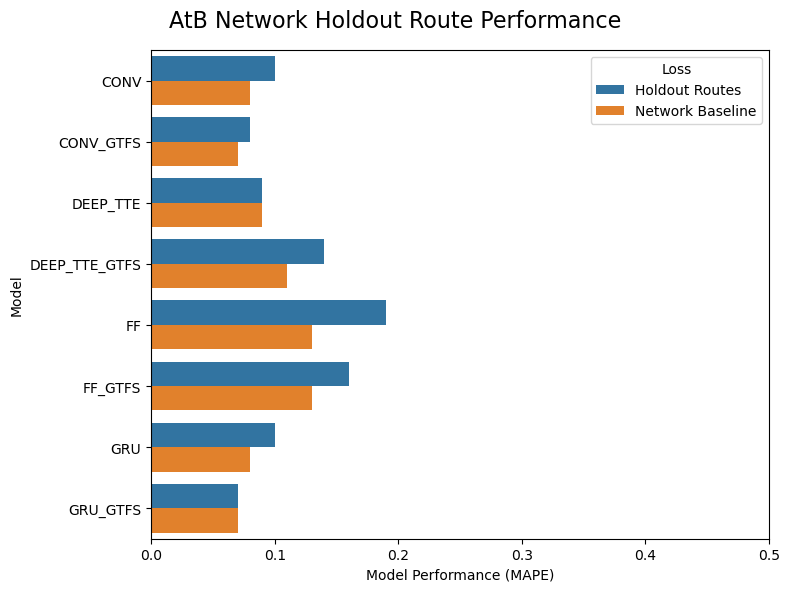

In [40]:
plot_data = atb_gen_df[atb_gen_df['Loss']=="Holdout_Losses"].copy()
plot_data = pd.concat([plot_data, atb_baseline_df])
plot_data = plot_data[~plot_data['Model'].isin(["AVG","SCH","PER_TIM","TRSF","TRSF_GTFS"])]
plot_data['Loss'] = plot_data['Loss'].replace(["Holdout_Losses"],["Holdout Routes"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.barplot(plot_data, x="MAPE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0, .5])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAPE)")
fig.suptitle('AtB Network Holdout Route Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_holdout_route_atb.png", dpi=600, bbox_inches='tight')

### Fine Tuning

In [50]:
atb_gen_df[atb_gen_df['Loss']=="Tune_Train_Losses"]

,Model,City,Loss,Fold,MAPE,RMSE,MAE
0,AVG,Trondheim,Tune_Train_Losses,0,0.23,186.710000,125.240000
3,CONV,Trondheim,Tune_Train_Losses,0,0.09,90.980003,57.119999
3,CONV_GTFS,Trondheim,Tune_Train_Losses,0,0.09,91.510002,56.830002
3,DEEP_TTE,Trondheim,Tune_Train_Losses,0,0.20,163.720001,122.470001
3,DEEP_TTE_GTFS,Trondheim,Tune_Train_Losses,0,0.22,170.449997,128.720001
3,FF,Trondheim,Tune_Train_Losses,0,0.28,201.520004,144.720001
3,FF_GTFS,Trondheim,Tune_Train_Losses,0,0.20,180.839996,128.300003
3,GRU,Trondheim,Tune_Train_Losses,0,0.09,93.849998,57.770000
3,GRU_GTFS,Trondheim,Tune_Train_Losses,0,0.09,91.169998,54.680000
1,PER_TIM,Trondheim,Tune_Train_Losses,0,0.15,134.690000,96.550000


In [51]:
atb_gen_df[atb_gen_df['Loss']=="Train_Losses"]

,Model,City,Loss,Fold,MAPE,RMSE,MAE
0,AVG,Trondheim,Train_Losses,0,0.23,186.710000,125.240000
3,CONV,Trondheim,Train_Losses,0,0.08,73.180000,49.830002
3,CONV_GTFS,Trondheim,Train_Losses,0,0.07,68.199997,43.049999
3,DEEP_TTE,Trondheim,Train_Losses,0,0.09,84.820000,54.160000
3,DEEP_TTE_GTFS,Trondheim,Train_Losses,0,0.11,86.900002,60.540001
3,FF,Trondheim,Train_Losses,0,0.13,95.339996,70.019997
3,FF_GTFS,Trondheim,Train_Losses,0,0.13,84.199997,63.209999
3,GRU,Trondheim,Train_Losses,0,0.08,84.900002,52.209999
3,GRU_GTFS,Trondheim,Train_Losses,0,0.07,81.320000,44.660000
1,PER_TIM,Trondheim,Train_Losses,0,0.15,134.690000,96.550000


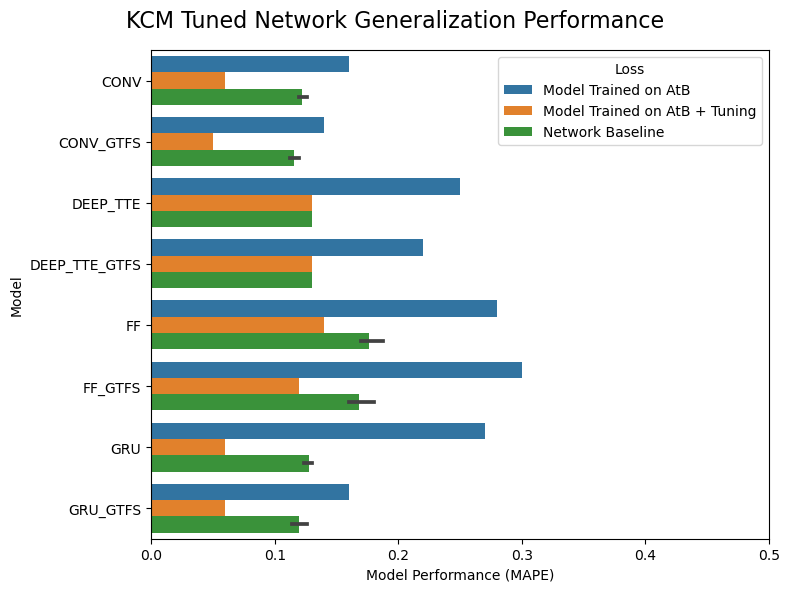

In [41]:
plot_data = atb_gen_df[atb_gen_df['Loss'].isin(['Tune_Test_Losses','Test_Losses'])]
plot_data = pd.concat([plot_data, kcm_baseline_df])
plot_data = plot_data[~plot_data['Model'].isin(["AVG","SCH","PER_TIM","TRSF","TRSF_GTFS"])]
plot_data['Loss'] = plot_data['Loss'].replace(["Tune_Test_Losses","Test_Losses"],["Model Trained on AtB + Tuning", "Model Trained on AtB"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.barplot(plot_data, x="MAPE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0, .5])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAPE)")
fig.suptitle('KCM Tuned Network Generalization Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_tuning_kcm.png", dpi=600, bbox_inches='tight')

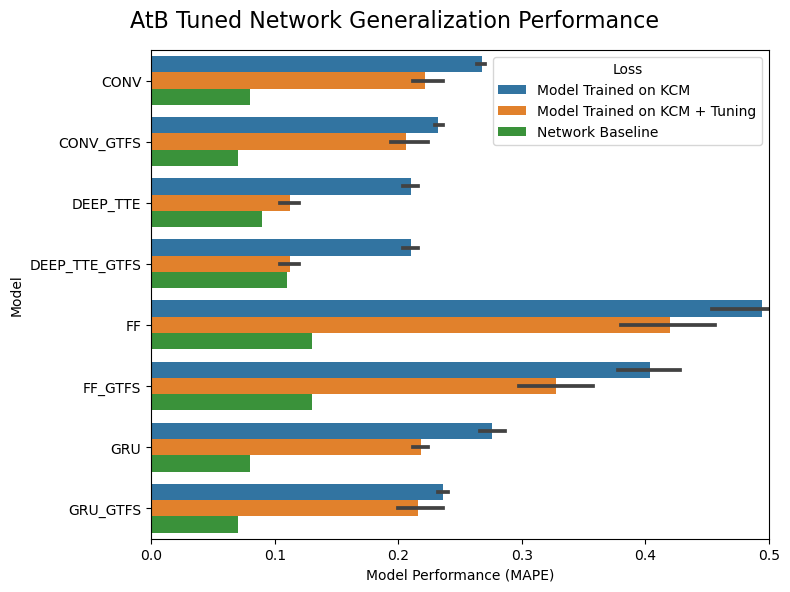

In [42]:
plot_data = kcm_gen_df[kcm_gen_df['Loss'].isin(['Tune_Test_Losses','Test_Losses'])]
plot_data = pd.concat([plot_data, atb_baseline_df])
plot_data = plot_data[~plot_data['Model'].isin(["AVG","SCH","PER_TIM","TRSF","TRSF_GTFS"])]
plot_data['Loss'] = plot_data['Loss'].replace(["Tune_Test_Losses","Test_Losses"],["Model Trained on KCM + Tuning", "Model Trained on KCM"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.barplot(plot_data, x="MAPE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0, .5])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAPE)")
fig.suptitle('AtB Tuned Network Generalization Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_tuning_atb.png", dpi=600, bbox_inches='tight')

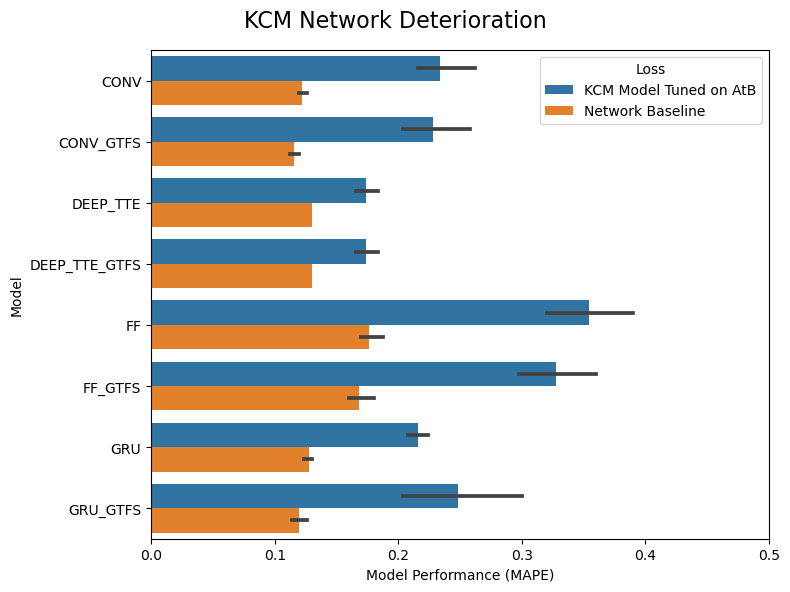

In [43]:
plot_data = kcm_gen_df[kcm_gen_df['Loss']=="Tune_Train_Losses"]
plot_data = pd.concat([plot_data, kcm_baseline_df])
plot_data = plot_data[~plot_data['Model'].isin(["AVG","SCH","PER_TIM","TRSF","TRSF_GTFS"])]
plot_data['Loss'] = plot_data['Loss'].replace(["Tune_Train_Losses"],["KCM Model Tuned on AtB"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.barplot(plot_data, x="MAPE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0,.5])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAPE)")
fig.suptitle('KCM Network Deterioration', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_deterioration_kcm.png", dpi=600, bbox_inches='tight')

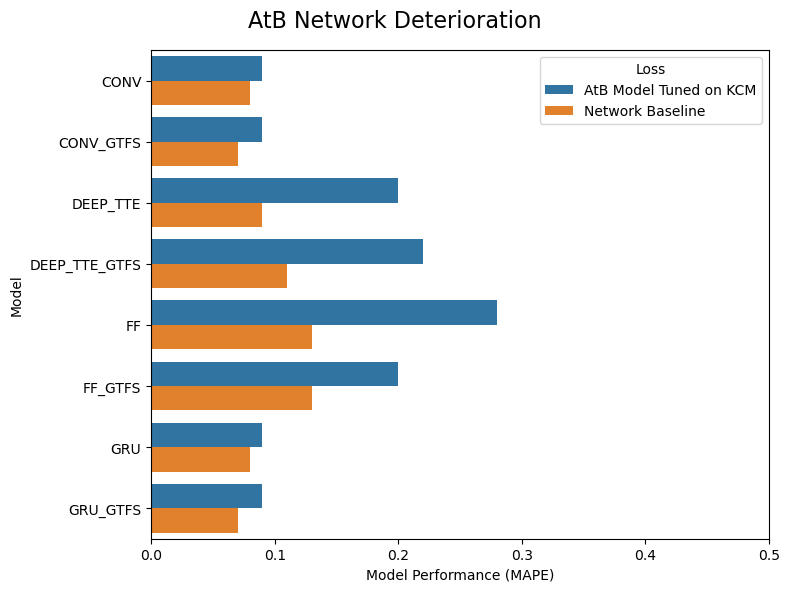

In [44]:
plot_data = atb_gen_df[atb_gen_df['Loss']=="Tune_Train_Losses"]
plot_data = pd.concat([plot_data, atb_baseline_df])
plot_data = plot_data[~plot_data['Model'].isin(["AVG","SCH","PER_TIM","TRSF","TRSF_GTFS"])]
plot_data['Loss'] = plot_data['Loss'].replace(["Tune_Train_Losses"],["AtB Model Tuned on KCM"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.barplot(plot_data, x="MAPE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0,.5])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAPE)")
fig.suptitle('AtB Network Deterioration', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_deterioration_atb.png", dpi=600, bbox_inches='tight')

### Mixed Data

In [45]:
# Need to combine model results for all models
model_list = [x for x in os.listdir(run_folder_mix) if (x[-3:]!="pkl" and x!=".DS_Store")]
all_model_results = []
all_model_times = []
all_model_gen_results = []
all_model_curves = []
for i, m in enumerate(model_list):
    training_results = data_utils.load_pkl(f"{run_folder_mix}{m}/model_results.pkl")
    results_df, time_df = data_utils.extract_results(training_results, "Mixed")
    curve_df = data_utils.extract_lightning_results(m, f"{run_folder_kcm}{m}/logs/{m}", "Mixed")
    curve_df = curve_df[curve_df["Loss Set"].isin(["Train","Valid"])]
    if m[-4:]!="GRID":
        gen_results = data_utils.load_pkl(f"{run_folder_kcm}{m}/model_generalization_results.pkl")
        gen_df = data_utils.extract_gen_results(gen_results, "Mixed")
    if i!=0:
        results_df = results_df[results_df['Model']==m]
        time_df = time_df[time_df['Model']==m]
        gen_df = gen_df[gen_df['Model']==m]
    all_model_results.append(results_df)
    all_model_times.append(time_df)
    all_model_gen_results.append(gen_df)
    all_model_curves.append(curve_df)
mix_result_df = pd.concat(all_model_results).sort_values(["Model","Fold"])
mix_time_df = pd.concat(all_model_times).sort_values(["Model","Fold"])
mix_gen_df = pd.concat(all_model_gen_results).sort_values(["Model","Fold"])
mix_curve_df = pd.concat(all_model_curves).sort_values(["Model","Fold"])

mix_baseline_df = mix_gen_df[mix_gen_df['Loss']=="Train_Losses"].copy()
mix_baseline_df['Loss'] = "Network Baseline"
mix_baseline_df = mix_baseline_df[['Model','City','Loss','Fold','MAPE','RMSE','MAE']]

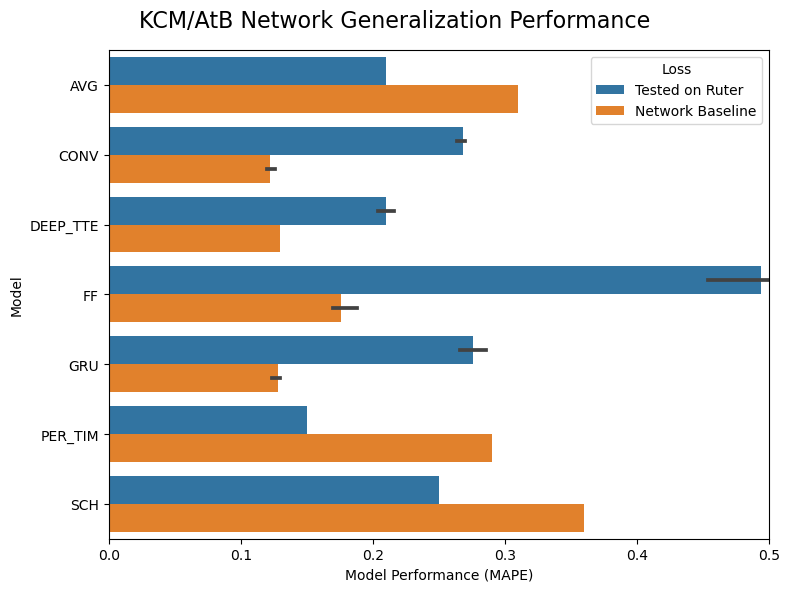

In [46]:
plot_data = mix_gen_df[mix_gen_df['Loss']=="Test_Losses"].copy()
plot_data = pd.concat([plot_data, mix_baseline_df])
plot_data = plot_data[~plot_data['Model'].isin(["TRSF","TRSF_GTFS"])]
plot_data['Loss'] = plot_data['Loss'].replace(["Test_Losses"],["Tested on Ruter"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.barplot(plot_data, x="MAPE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0,.5])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAPE)")
fig.suptitle('KCM/AtB Network Generalization Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_generalization_mix.png", dpi=600, bbox_inches='tight')